In [1]:
import torch
import os
from torchvision import datasets, transforms
import torch.nn as nn
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from utils import plot_tsne, tensors_as_images, dataset_first_n, plot_fit
import random
import argparse
import itertools

import IPython.display


import mnist_nets
import training

NUM_CLASSES = 10
EPOCHS = 100

In [2]:
def freeze_seeds(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)


In [3]:
args = argparse.Namespace()
args.seed = 0
args.data_path = "/datasets/cv_datasets/data"
args.batch_size = 32
args.latent_dim = 128
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'
args.mnist = True
args.self_supervised = False

In [4]:
freeze_seeds(args.seed)

In [5]:

if args.mnist:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.1307], std=[0.3081])  
    ])
    train_dataset = datasets.MNIST(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root=args.data_path, train=False, download=True, transform=transform)
else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])  
    ])
    train_dataset = datasets.CIFAR10(root=args.data_path, train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root=args.data_path, train=False, download=True, transform=transform)

(<Figure size 1000x1000 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

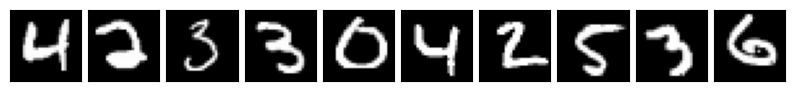

In [6]:

dataset_first_n(train_dataset, 10, figsize=(10,10), nrows=1, cmap='gray')

In [7]:


#Data
# When you create your dataloader you should split train_dataset or test_dataset to leave some aside for validation
ds_val, ds_train = torch.utils.data.random_split(train_dataset, [0.2, 0.8])

# ds_train = torch.utils.data.Subset(ds_train, range(100))


dl_train = torch.utils.data.DataLoader(ds_train, batch_size=args.batch_size, shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=args.batch_size, shuffle=False)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False)

dl_sample = itertools.cycle(torch.utils.data.DataLoader(ds_train, batch_size=7, shuffle=True))

img_shape = train_dataset[0][0].shape



In [8]:

#Model
model = mnist_nets.AE(img_shape, args.latent_dim).to(args.device)
model_dp = torch.nn.DataParallel(model)

# imgs, _ = next(dl_sample)
# imgs = imgs.to(args.device)
# model.sample(imgs)


#Optimizer
optimizer = torch.optim.Adam(model.parameters())

#Loss
loss_fn = torch.nn.L1Loss()

#Trainer
trainer = training.AETrainer(model_dp, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/mnist_ae'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [9]:

# imgs, _ = next(dl_sample)

# model.sample(imgs)

# for name, param in model.named_parameters():
#     print(f"{name}: requires_grad = {param.requires_grad}")


In [10]:

model

AE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 12, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.01)
      (2): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(12, 24, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): LeakyReLU(negative_slope=0.01)
      (5): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(24, 48, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (7): LeakyReLU(negative_slope=0.01)
      (8): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=432, out_features=128, bias=True)
    )
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=128, out_features=432, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
      (2): Unflatten(dim=1, unflattened_size

In [11]:
def post_epoch_fn(epoch, train_result, test_result, verbose):
    # Plot some samples if this is a verbose epoch
    if verbose:
        imgs, _ = next(dl_sample)
        imgs = imgs.to(args.device)
        recon_imgs = model.sample(imgs)

        fig, _ = tensors_as_images(list(imgs), figsize=(6,3),cmap='gray')
        IPython.display.display(fig)
        plt.close(fig)

        fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3), cmap='gray')
        IPython.display.display(fig)
        plt.close(fig)

In [12]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
    saved_state = torch.load(f'{checkpoint_file}.pt', map_location=args.device)
    model_dp.load_state_dict(saved_state['model_state'])
    model = model_dp.module
    
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=EPOCHS, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,
                      post_epoch_fn=post_epoch_fn)


*** Loading final checkpoint file checkpoints/mnist_ae_final instead of training


C:\Users\matan\AppData\Local\Temp\ipykernel_27392\4180352256.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(f'{checkpoint_file}.pt', map_locati

*** Images reconstructed from best model:


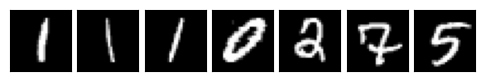

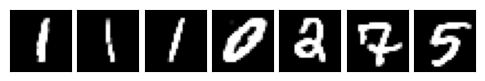

In [13]:

# Plot images from best model
print('*** Images reconstructed from best model:')
imgs, _ = next(dl_sample)
imgs = imgs.to(args.device)
recon_imgs = model.sample(imgs)

fig, _ = tensors_as_images(list(imgs), figsize=(6,3), cmap='gray')
IPython.display.display(fig)
plt.close(fig)

fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3), cmap='gray')
IPython.display.display(fig)
plt.close(fig)


In [14]:
# checking best model MAE
trainer.loss_fn = torch.nn.L1Loss()
res = trainer.test_epoch(dl_test)
recon_mae = sum(res.losses) / len(res.losses)

print(f'*** Best model mean abs error: {recon_mae:.4f}')

test_batch (Avg. Loss 0.212, Accuracy 15.1): 100%|██████████| 313/313 [00:03<00:00, 103.25it/s]
*** Best model mean abs error: 0.2121


In [15]:
encoder = model_dp.module.encoder
for param in encoder.parameters():
    param.requires_grad = False  # Freezes encoder


In [16]:
#Model
classifier = mnist_nets.Classifier(encoder,args.latent_dim, NUM_CLASSES).to(args.device)
# classifier_dp = torch.nn.DataParallel(classifier)

#Optimizer
optimizer = torch.optim.Adam(classifier.parameters())

#Loss
loss_fn = torch.nn.CrossEntropyLoss()

#Trainer
trainer = training.ClassifierTrainer(classifier, loss_fn, optimizer, args.device)

checkpoint_file = 'checkpoints/mnist_classifier'
checkpoint_file_final = f'{checkpoint_file}_final'
if os.path.isfile(f'{checkpoint_file}.pt'):
    os.remove(f'{checkpoint_file}.pt')

In [17]:

if os.path.isfile(f'{checkpoint_file_final}.pt'):
    print(f'*** Loading final checkpoint file {checkpoint_file_final} instead of training')
    checkpoint_file = checkpoint_file_final
else:
    res = trainer.fit(dl_train, dl_val,
                      num_epochs=EPOCHS, early_stopping=10, print_every=5,
                      checkpoints=checkpoint_file,)
    plot_fit(res)

*** Loading final checkpoint file checkpoints/mnist_classifier_final instead of training


# Evaluation


##  2. Quantitative Results

*** results from best model:


C:\Users\matan\AppData\Local\Temp\ipykernel_27392\1190973151.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  saved_state = torch.load(f'{checkpoint_file}.pt', map_locati

(<Figure size 1600x1000 with 4 Axes>,
 array([<Axes: title={'center': 'train_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'train_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>,
        <Axes: title={'center': 'validation_loss'}, xlabel='Iteration #', ylabel='Loss'>,
        <Axes: title={'center': 'validation_acc'}, xlabel='Epoch #', ylabel='Accuracy (%)'>],
       dtype=object))

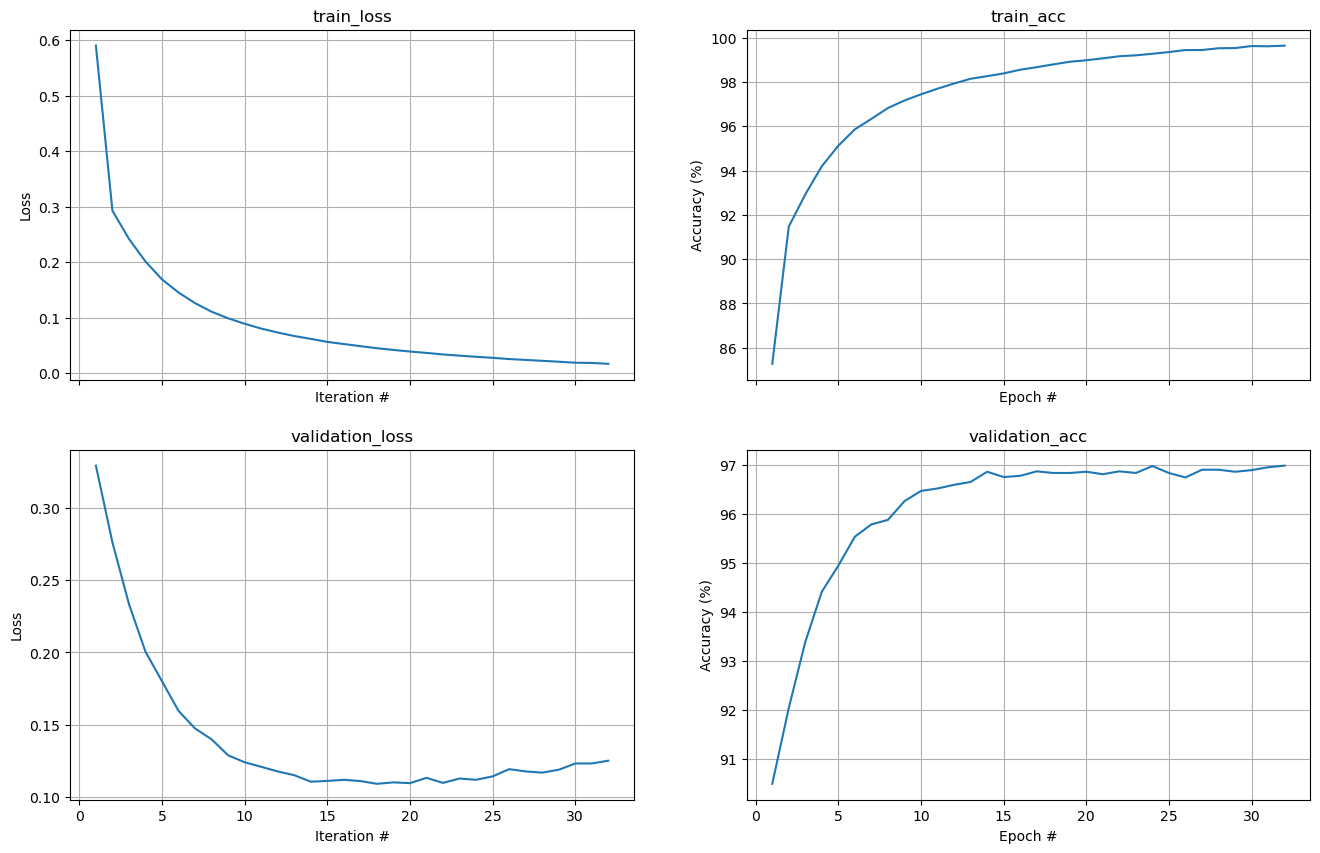

In [18]:

print('*** results from best model:')
saved_state = torch.load(f'{checkpoint_file}.pt', map_location=args.device)
classifier.load_state_dict(saved_state['model_state'])
res = saved_state['fit_result']
plot_fit(res)   

In [19]:

res = trainer.test_epoch(dl_test)
print(f'Accuracy on test set: {res.accuracy:.2f}')
print(f" Accuracy on validation set: {saved_state['best_epoch_test_acc']}")
print(f" Accuracy on training set: {saved_state['best_epoch_train_acc']}")
print(f'Best model mean abs error: {recon_mae:.4f}')

test_batch (Avg. Loss 0.110, Accuracy 97.0): 100%|██████████| 313/313 [00:02<00:00, 113.06it/s]
Accuracy on test set: 97.03
 Accuracy on validation set: 96.99166666666666
 Accuracy on training set: 99.63958333333333
Best model mean abs error: 0.2121


##  3. Qualitative Results

*** Images reconstructed from best model:


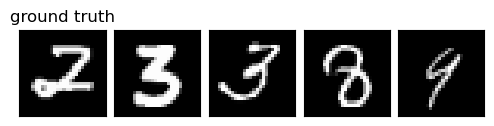

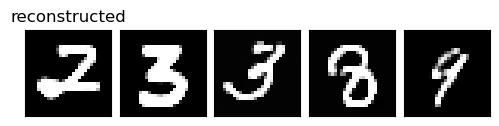

In [20]:
dl_sample = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=True)
print('*** Images reconstructed from best model:')
imgs, _ = next(iter(dl_sample))
imgs = imgs.to(args.device)
recon_imgs = model.sample(imgs)

fig, _ = tensors_as_images(list(imgs), figsize=(6,3), cmap='gray', titles=['ground truth'])
IPython.display.display(fig)
plt.close(fig)

fig, _ = tensors_as_images(list(recon_imgs), figsize=(6,3), cmap='gray', titles=['reconstructed'])
IPython.display.display(fig)
plt.close(fig)


## 4. Linear Interpolation

(<Figure size 600x300 with 2 Axes>,
 array([<Axes: title={'center': 'ground truth'}>, <Axes: >], dtype=object))

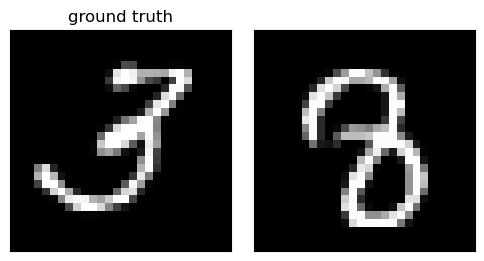

In [21]:
imgs = imgs[2:4]
tensors_as_images(list(imgs), figsize=(6,3), cmap='gray', titles=['ground truth'])

(<Figure size 600x300 with 10 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
        <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object))

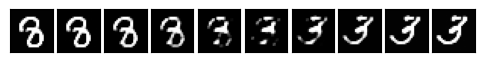

In [22]:
model.eval()

with torch.no_grad():
    z1, z2 = model.encoder(imgs)

alphas = np.linspace(0, 1, 10)
z1 = z1.unsqueeze(0) 
z2 = z2.unsqueeze(0) 

alphas = torch.tensor(np.linspace(0, 1, 10), dtype=torch.float32).view(-1, 1) 

z_interp = alphas * z1 + (1 - alphas) * z2 

with torch.no_grad():
    recon_imgs = model.decoder(z_interp)


tensors_as_images(list(recon_imgs), figsize=(6, 3), cmap='gray')


## 5. t-SNE

In [23]:
img_file = f"tsne_images/{checkpoint_file.replace('checkpoints/','')}"
if not os.path.isfile(f'{img_file}_latent_tsne.png') and 'final' not in checkpoint_file:
    plot_tsne(classifier.encoder, dl_test, args.device, img_file)